In [1]:
import matplotlib.pyplot as plt
import numpy as np
from DynGenModels.trainer.trainer import DynGenModelTrainer

def plot_gaussians(data, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

# Deconvolving 3 Perpendicular Gaussians: Normalizing flows

### inference without pre-processing:

#=================================================================================
INFO: created directory: ../results/MAF_RQS.smeared_gaussians_2023.10.03_18h55__1
#=================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| features            | ['x', 'y']                                      |
| data_name           | smeared_gaussians                               |
| num_points          | 60000                                           |
| dim_input           | 2                                               |
| noise_cov           | [[0.1, 0], [0, 1]]                              |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | x: [-2.0, 1.0]                                  |
|           

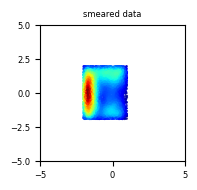

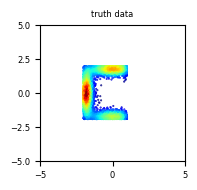

INFO: number of training parameters: 48630


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.deconvolution_configs import Deconvolution_Gauss_MAF_RQS_NormFlow as Configs

configs = Configs(data_name = 'smeared_gaussians',
                num_points = 60000,
                data_split_fracs = [0.8, 0.2, 0.0],
                noise_cov = [[0.1,0],[0,1]],
                cuts = {'x':[-2.0, 1.0], 
                        'y':[-1.9, 2.0]},
                preprocess=['normalize', 'logit_transform', 'standardize'],
                num_transforms=5,
                tail_bound=10,
                num_bins=20,
                batch_size = 256,
                epochs = 10,
                early_stopping = None,
                warmup_epochs = None,
                print_epochs = 5,
                lr = 1e-3,
                dim_hidden = 128, 
                device = 'cpu',
                seed = 12345,
                num_mc_draws = 30
               )

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.deconvolution.datasets import RectifiedSmearedGaussDataset
from DynGenModels.datamodules.deconvolution.dataloader import ToysDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.deconvolution import DeconvolutionNormFlows

dataset = RectifiedSmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)
net = MAFPiecewiseRQS(configs)
dynamics = DeconvolutionNormFlows(net, configs)
maf = DynGenModelTrainer(dynamics, dataloader, configs)

plot_gaussians(dataset.smeared, title='smeared data', num_points=10000)
plot_gaussians(dataset.truth, title='truth data', num_points=10000)

maf.train()

We wish to recover the truth distribution $q(y)$ (left plots) given the smeared one $p(x)$ (middle plots) and the noise model assumed to be Gaussian. This is equivalkent to the deconvolution problem $x = y + \epsilon$:

$p(x) = q\star \mathcal{N}(x) = \int d\epsilon\, p(x-\epsilon)\mathcal{N}(0, \Sigma^2)$

we show two cases: (i) 3 perependicular gaussian distributions and, (ii) the same distributions but with hard edges corresponding to cuts. This last situtation is a toy model for Gaia data where all stars fall inside a ball of fixed radius $R$.

The plots in the last column show the results for a trained normalizing flow deconvolution. The case without cuts works well, one can see that the procedure is trying to unsmear the data back to the truth shape. When cuts are imposed the deconvolution does not work well becasue of the data discontinuities. For this reason we need to use preprocessing...



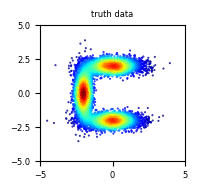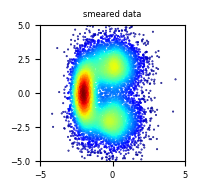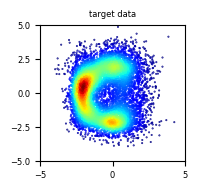

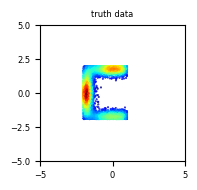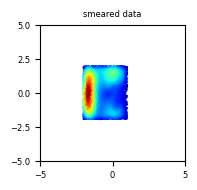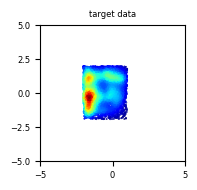

In [ ]:
dataset.preprocess_methods

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.deconvolution.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)
plot_gaussians(pipeline.target, title='target data')


### Inference with preprocessing
The above deconvolution works pretty well... I run into issues when we decide to preprocess the data with non-linear fucntions

$\phi: x\to x^\prime$ 

The distroy the linearity $x = y+\epsilon$, i.e. the deinsity of $p(x^\prime)$ in the transfrimed space is no longer a convolution integral. One can see this explicitly in the results below:

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.deconvolution.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)
plot_gaussians(pipeline.target, title='target data')


Even just a linear 'normalization' the results are ditorted... 

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.deconvolution.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)
plot_gaussians(pipeline.target, title='target data')

### Inference with preprocessing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from DynGenModels.configs.toys_configs import Deconv_Gauss_MAF_RQS_NormFlow as Configs

configs = Configs(data_name = 'gauss_to_2moons',
                num_points = 20000,
                data_split_fracs = [0.8, 0.2, 0.0],
                noise_cov = [[0.1,0],[0,1]],
                preprocess=['normalize', 'logit_transform', 'standardize'],
                cuts = {'x':[-2.0, 1.0], 'y':[-np.inf, 2.0]},
                num_transforms=3,
                tail_bound=10,
                num_bins=20,
                batch_size = 256,
                epochs = 100,
                early_stopping = None,
                warmup_epochs = None,
                print_epochs = 20,
                lr = 1e-3,
                dim_hidden = 16, 
                device = 'cpu',
                seed = 12345
               )

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.toys.datasets import RectifiedSmearedGaussDataset
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow

dataset = RectifiedSmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)
net = MAFPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
maf = DynGenModelTrainer(dynamics, dataloader, configs)
maf.train()

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.toys.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)

plot_gaussians(dataset.source, title='source data', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='target data')
plot_gaussians(dataset.target, title='truth data', num_points=len(pipeline.target))

# Deconvolution: Flow-Matching

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from DynGenModels.trainer.trainer import DynGenModelTrainer

#=============================================================================
INFO: created directory: ../results/MLP.smeared_gaussians_2023.10.05_00h18__1
#=============================================================================
+--------------------+--------------------------+
| Parameters         | Values                   |
+--------------------+--------------------------+
| features           | ['x', 'y']               |
| data_name          | smeared_gaussians        |
| num_points         | 20000                    |
| dim_input          | 2                        |
| noise_cov          | [[0.3, 0.2], [0.2, 0.5]] |
| preprocess         | []                       |
| cuts               | x: [-inf, inf]           |
|                    | y: [-inf, inf]           |
| device             | cpu                      |
| data_split_fracs   | [0.8, 0.2, 0.0]          |
| batch_size         | 2000                     |
| epochs             | 300                      |
| lr          

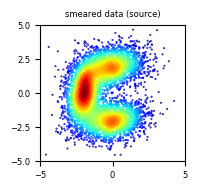

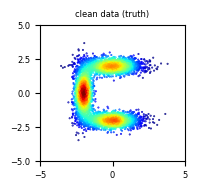

In [3]:

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.deconvolution_configs import Deconvolution_Gauss_MLP_FlowMatch as Configs

configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 20000,
                sigma = 0.0001,
                noise_cov = [[0.3, 0.2],
                             [0.2, 0.5]],
                data_split_fracs = [0.8, 0.2, 0.0],
                epochs = 300,
                batch_size = 2000,
                lr = 1e-3,
                dim_hidden = 64, 
                device = 'cpu',
                solver='midpoint',
                num_sampling_steps=200,
                seed = 12345
                )
                
configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.deconvolution.datasets import SmearedGaussDataset
from DynGenModels.datamodules.deconvolution.dataloader import ToysDataLoader 

dataset = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)

plot_gaussians(dataset.smeared, title='smeared data (source)', num_points=6000)
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=6000)


In [4]:
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.deconvolution import DeconvolutionFlowMatching

mlp = MLP(configs)
cfm = DynGenModelTrainer(dynamics=DeconvolutionFlowMatching(mlp, configs), 
                         dataloader=dataloader,
                         configs=configs)

cfm.train()

INFO: number of training parameters: 8706


epochs:   0%|          | 0/300 [00:00<?, ?it/s]

INFO: neural ODE solver with midpoint method and steps=200


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


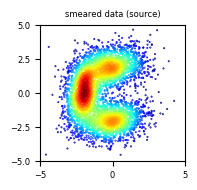

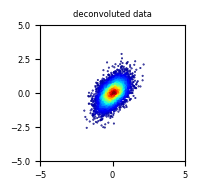

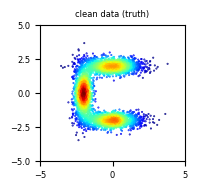

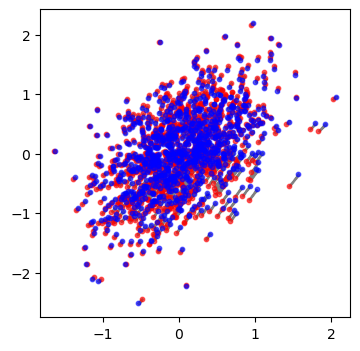

In [5]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline as Pipeline

noise = torch.distributions.MultivariateNormal(torch.zeros(2), torch.Tensor(configs.noise_cov)).sample((5000,))
pipeline = Pipeline(trained_model=cfm, source_input=noise , configs=configs)


#...plot densities:

plot_gaussians(dataset.smeared, title='smeared data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))

#...plot trajectories:

num_points=1000
fig, ax = plt.subplots(1,1, figsize=(4,4))
for i in range(configs.num_sampling_steps): 
    plt.scatter(pipeline.trajectories[i][:num_points,0], pipeline.trajectories[i][:num_points,1], s=0.1, color='gray', alpha=0.3)
plt.scatter(pipeline.trajectories[0][:num_points,0], pipeline.trajectories[0][:num_points,1], s=10, color='red', alpha=0.6)
plt.scatter(pipeline.trajectories[-1][:num_points,0], pipeline.trajectories[-1][:num_points,1], s=10, color='blue', alpha=0.6)
plt.show()

# Deconvolution Normalizing Flows

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from DynGenModels.trainer.trainer import DynGenModelTrainer

In [ ]:

from DynGenModels.configs.toys_configs import Deconv_Gauss_MAF_RQS_NormFlow as Configs


configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 30000,
                noise_cov = [[0.1,0],[0,1]],
                data_split_fracs = [0.8, 0.19, 0.01],
                epochs = 10,
                early_stopping=30,
                batch_size = 256,
                warmup_epochs = 20,
                print_epochs = 10,
                lr = 5e-4,
                dim_hidden = 128, 
                device = 'cpu',
                seed = 12345,
                num_transforms = 2,
                num_gen_samples = 6000,
                num_mc_draws = 30
                )

configs.set_workdir(path='../results', save_config=True)

In [ ]:
from DynGenModels.datamodules.toys.datasets import SmearedGaussDataset
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader

dataset = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)

In [ ]:
from DynGenModels.dynamics.nf.deconvolution import DeconvolutionNormFlows
from DynGenModels.models.maf import  MAFPiecewiseRQS

maf = MAFPiecewiseRQS(configs)
nflow = DynGenModelTrainer(dynamics=DeconvolutionNormFlows(maf, configs), 
                           dataloader=dataloader,
                           configs=configs)

nflow.train()

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline
pipeline = NormFlowPipeline(trained_model=nflow, configs=configs, num_gen_samples=6000)

In [ ]:

def plot_gaussians(data, num_points=None, title=None):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


plot_gaussians(dataset.source, title='noisy data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data (target)')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))